# Import

In [1]:
import os
import sys

import json
import math
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import pytransform3d
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.plot_utils import make_3d_axis, plot_vector
from urdf_parser_py.urdf import URDF

# Helper Functions

In [2]:
%matplotlib widget

def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str

# Intialization

In [3]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
urdf_path = os.path.join(os.getcwd(),"..","urdf","chest_grace_cam.urdf")
robot = URDF.from_xml_file(urdf_path)

# URDF

# URDF Parameters Edit

In [4]:
# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = 0.0325 + 0  # Offset
        joint.origin.position[1] = -0.05692 + 0
        joint.origin.position[2] = -0.12234 + 0
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = 0 + 0
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = 0.13172 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = 0.08492 + 0
        joint.origin.position[2] = 0.05186 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = 0.02895 + 0
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -0.02895 + 0
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = -1.5708 + 0.03457662014401592  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[1] = 0 + 0
        joint.origin.rotation[2] = -1.5708 + 0.18913797017088096  # Orientation Offset: Right Hand Rule (Positive CCW)
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = -1.5708 + 0.05553511593216458  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[1] = 0 + 0
        joint.origin.rotation[2] = -1.5708 + -0.2544206094843146  # Orientation Offset: Right Hand Rule (Positive CCW)
        
# XML to String
urdf_str = xml_to_str(robot)

## Visualize URDF

In [5]:
tm = UrdfTransformManager()
joints_list = ["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"]

In [6]:
tm.load_urdf(urdf_str)

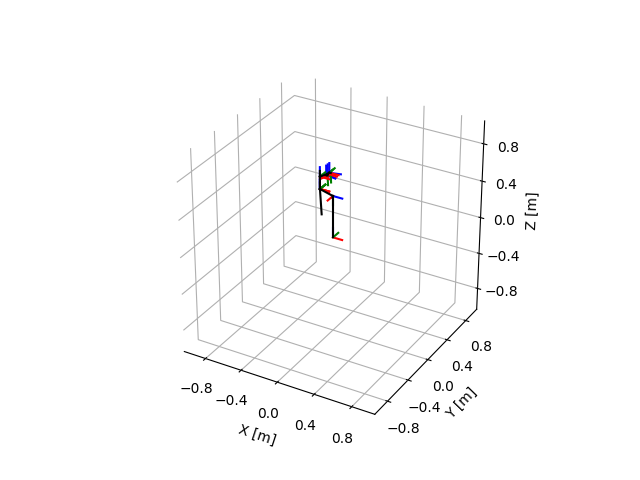

In [7]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("robot", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("robot", ax=ax)
plt.show()

## Setting the Joints

In [8]:
# Motor Cmd Value

cmd_lnp = math.radians(10)
cmd_lnt = math.radians(10)
cmd_unt = math.radians(10)
cmd_et = math.radians(10)
cmd_lep = math.radians(5)
cmd_rep = math.radians(5)

In [9]:
# Transforms

neck_pitch = cmd_lnt*0.5 + 0
neck_yaw = cmd_lnp*0.5 + 0
head_pitch = cmd_unt*0.5 + 0
eyes_pitch = cmd_et*0.4 + 0
lefteye_yaw = cmd_lep*1.6 + 0
righteye_yaw = cmd_rep*1.7 + 0

In [10]:
# Setting the Joints

tm.set_joint('neck_pitch', neck_pitch)
tm.set_joint('neck_yaw', neck_yaw)
tm.set_joint('head_pitch', head_pitch)
tm.set_joint('eyes_pitch', eyes_pitch)
tm.set_joint('lefteye_yaw', lefteye_yaw)
tm.set_joint('righteye_yaw', righteye_yaw)

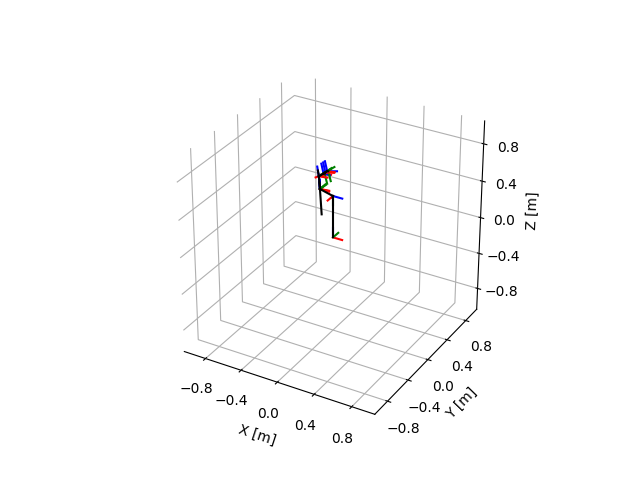

In [11]:
# Visualize
plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in("robot", whitelist=joints_list,
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("robot", ax=ax)
plt.show()

In [12]:
# Function Prototype

def motor_cmd_joint(cmd_lnp,cmd_lnt,cmd_unt,cmd_et,cmd_lep,cmd_rep):  # degrees
    cmd_lnp = math.radians(cmd_lnp)
    cmd_lnt = math.radians(cmd_lnt)
    cmd_unt = math.radians(cmd_unt)
    cmd_et = math.radians(cmd_et)
    cmd_lep = math.radians(cmd_lep)
    cmd_rep = math.radians(cmd_rep)

    neck_pitch = cmd_lnt*0.5 + 0
    neck_yaw = cmd_lnp*0.5 + 0
    head_pitch = cmd_unt*0.5 + 0
    eyes_pitch = cmd_et*0.4 + 0
    lefteye_yaw = cmd_lep*1.6 + 0
    righteye_yaw = cmd_rep*1.7 + 0

    res_dict = {
        "neck_pitch": neck_pitch,
        "neck_yaw": neck_yaw,
        "head_pitch": head_pitch,
        "eyes_pitch": eyes_pitch,
        "lefteye_yaw": lefteye_yaw,
        "righteye_yaw": righteye_yaw,
    }

    return res_dict


In [13]:
# Testing the Function

motor_cmd_joint(cmd_lnp=10,cmd_lnt=10,cmd_unt=10,cmd_et=10,cmd_lep=5,cmd_rep=5)

{'neck_pitch': 0.08726646259971647,
 'neck_yaw': 0.08726646259971647,
 'head_pitch': 0.08726646259971647,
 'eyes_pitch': 0.06981317007977318,
 'lefteye_yaw': 0.13962634015954636,
 'righteye_yaw': 0.148352986419518}

# Camera Angle Rotation Offset

## Undistort Points

In [14]:
# Gaze Centers

left_gaze_pt_x = gaze_ctrs['left_eye']['x_center']
left_gaze_pt_y = gaze_ctrs['left_eye']['y_center']
right_gaze_pt_x = gaze_ctrs['right_eye']['x_center']
right_gaze_pt_y = gaze_ctrs['right_eye']['y_center']
print("left_gaze_pt_x:", left_gaze_pt_x)
print("left_gaze_pt_y:", left_gaze_pt_y)
print("right_gaze_pt_x:", right_gaze_pt_x)
print("right_gaze_pt_y:", right_gaze_pt_y)

left_gaze_pt_x: 411
left_gaze_pt_y: 235
right_gaze_pt_x: 151
right_gaze_pt_y: 246


In [15]:
# Normalized Point (z=1.0)
left_undistort_pts = cv2.undistortPoints((left_gaze_pt_x, left_gaze_pt_y), 
                                         np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                         np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_undistort_pts = cv2.undistortPoints((right_gaze_pt_x, right_gaze_pt_y), 
                                          np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                          np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('left_undistort_pts:', left_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System
print('right_undistort_pts:', right_undistort_pts)  # For Y, Downwards is + because of Camera Opencv Coordinate System

left_undistort_pts: [[[0.19142607 0.03459041]]]
right_undistort_pts: [[[-0.2600561   0.05559228]]]


In [16]:
# Undistored Points

left_x_prime = left_undistort_pts.squeeze()[0]
left_y_prime = left_undistort_pts.squeeze()[1]
right_x_prime = right_undistort_pts.squeeze()[0]
right_y_prime = right_undistort_pts.squeeze()[1]

print('left_x_prime:',left_x_prime)
print('left_y_prime:',left_y_prime)
print('right_x_prime:',right_x_prime)
print('right_y_prime:',right_y_prime)

left_x_prime: 0.19142607185001126
left_y_prime: 0.034590406011504184
right_x_prime: -0.26005610414060365
right_y_prime: 0.055592279312658976


In [17]:
# Checking of Undistortion
left_pixels,_ = cv2.projectPoints((left_undistort_pts.squeeze()[0], left_undistort_pts.squeeze()[1], 1.0), 
                                np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['left_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['left_eye']['distortion_coefficients']))
right_pixels,_ = cv2.projectPoints((right_undistort_pts.squeeze()[0], right_undistort_pts.squeeze()[1], 1.0), 
                                 np.array([0.0,0.0,0.0]), np.array([0.0,0.0,0.0]), 
                                  np.array(cam_mtxs['right_eye']['camera_matrix']), 
                                  np.array(cam_mtxs['right_eye']['distortion_coefficients']))
print('left_pixels:', left_pixels)
print('right_pixels:',right_pixels)

left_pixels: [[[411. 235.]]]
right_pixels: [[[151.00000002 246.        ]]]


## Orientation Offset Calculation

In [18]:
left_yaw_offset = math.atan2(left_undistort_pts.squeeze()[0],1.0)  # radians unit
left_pitch_offset = math.atan2(left_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System
right_yaw_offset = math.atan2(right_undistort_pts.squeeze()[0],1.0) 
right_pitch_offset = math.atan2(right_undistort_pts.squeeze()[1],1.0) # For Y, Downwards is + because of Camera Opencv Coordinate System

print('left_yaw_offset(rad):', left_yaw_offset)
print('left_pitch_offset(rad)(opencv coord):', left_pitch_offset)
print('right_yaw_offset:(rad)', right_yaw_offset)
print('right_pitch_offset(rad)(opencv coord):', right_pitch_offset)
print('-----')

print('left_yaw_offset(deg):', math.degrees(left_yaw_offset))
print('left_pitch_offset(deg)(opencv coord):', math.degrees(left_pitch_offset))
print('right_yaw_offset(deg):', math.degrees(right_yaw_offset))
print('right_pitch_offset(deg)(opencv coord):', math.degrees(right_pitch_offset))

left_yaw_offset(rad): 0.18913797017088096
left_pitch_offset(rad)(opencv coord): 0.03457662014401592
right_yaw_offset:(rad) -0.2544206094843146
right_pitch_offset(rad)(opencv coord): 0.05553511593216458
-----
left_yaw_offset(deg): 10.836807436462736
left_pitch_offset(deg)(opencv coord): 1.981094404079137
right_yaw_offset(deg): -14.57722714459731
right_pitch_offset(deg)(opencv coord): 3.1819277576827667


# Generate Dataset

## Proving

In [19]:
mat = tm.get_transform('realsense','leftcamera')
mat

array([[ 0.99923429, -0.00436547, -0.03888159, -0.01677698],
       [ 0.01488928,  0.96141407,  0.27470219,  0.25933034],
       [ 0.0361821 , -0.27507076,  0.96074291, -0.0302694 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [20]:
# Example

in_pts = np.array([0.5,0.8,0.75,1]).reshape(-1,1)
out_pts = mat @ in_pts
print('in_pts:',in_pts)
print('out_pts:',out_pts)

in_pts: [[0.5 ]
 [0.8 ]
 [0.75]
 [1.  ]]
out_pts: [[0.4501866 ]
 [1.24193288]
 [0.48832222]
 [1.        ]]


In [21]:
# Solution
x_prime = out_pts[0,0]/out_pts[2,0]
y_prime = out_pts[1,0]/out_pts[2,0]
a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
b = np.array([-mat[0,2]*in_pts[2,0]-mat[0,3], -mat[1,2]*in_pts[2,0]-mat[1,3], -mat[2,2]*in_pts[2,0]-mat[2,3]])
x = np.linalg.solve(a, b)
x

array([0.5       , 0.8       , 0.48832222])

In [22]:
# Function Prototype

x_prime = out_pts[0,0]/out_pts[2,0]
y_prime = out_pts[1,0]/out_pts[2,0]
z = in_pts[2,0]

a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
b = np.array([-mat[0,2]*z-mat[0,3], -mat[1,2]*z-mat[1,3], -mat[2,2]*z-mat[2,3]])
x = np.linalg.solve(a, b)
x

array([0.5       , 0.8       , 0.48832222])

In [23]:
def generate_chest_dataset(mat, z, x_prime, y_prime): # Opencv coordinates
    a = np.array([[mat[0,0],mat[0,1],-x_prime],
              [mat[1,0],mat[1,1],-y_prime],
              [mat[2,0],mat[2,1],-1]])
    b = np.array([-mat[0,2]*z-mat[0,3], -mat[1,2]*z-mat[1,3], -mat[2,2]*z-mat[2,3]])
    x = np.linalg.solve(a, b)
    return np.append(x[:2],z)

In [24]:
# Testing the Function
generate_chest_dataset(mat=mat, z=in_pts[2,0], x_prime=out_pts[0,0]/out_pts[2,0], y_prime=out_pts[1,0]/out_pts[2,0])

array([0.5 , 0.8 , 0.75])

## Data Generation (Single)

In [25]:
# Robot Construction
robot = URDF.from_xml_file(urdf_path)

# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = 0.0325 + 0  # Offset
        joint.origin.position[1] = -0.05692 + 0
        joint.origin.position[2] = -0.12234 + 0
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = 0 + 0
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = 0.13172 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = 0.08492 + 0
        joint.origin.position[2] = 0.05186 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = 0.02895 + 0
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -0.02895 + 0
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = -1.5708 + 0.03457662014401592  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[1] = 0 + 0
        joint.origin.rotation[2] = -1.5708 + 0.18913797017088096  # Orientation Offset: Right Hand Rule (Positive CCW)
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = -1.5708 + 0.05553511593216458  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[1] = 0 + 0
        joint.origin.rotation[2] = -1.5708 + -0.2544206094843146  # Orientation Offset: Right Hand Rule (Positive CCW)
        
# XML to String
urdf_str = xml_to_str(robot)

# Transform Manager
tm = UrdfTransformManager()
tm.load_urdf(urdf_str)

In [26]:
# Initialization
z_depth = 1.0

# Motor Command
joint_dict = motor_cmd_joint(cmd_lnp=-45,cmd_lnt=30,cmd_unt=-30,cmd_et=10,cmd_lep=-5,cmd_rep=5)
tm.set_joint('neck_pitch', joint_dict['neck_pitch'])
tm.set_joint('neck_yaw', joint_dict['neck_yaw'])
tm.set_joint('head_pitch', joint_dict['head_pitch'])
tm.set_joint('eyes_pitch', joint_dict['eyes_pitch'])
tm.set_joint('lefteye_yaw', joint_dict['lefteye_yaw'])
tm.set_joint('righteye_yaw', joint_dict['righteye_yaw'])

# Get Transform
T_clprime = tm.get_transform('realsense','leftcamera')   # Opencv coords
T_crprime = tm.get_transform('realsense','rightcamera')   # Opencv coords

# Get Camera Chest Points
X_C_L = generate_chest_dataset(mat=T_clprime, z=z_depth, x_prime=left_x_prime, y_prime=left_y_prime)
X_C_R = generate_chest_dataset(mat=T_crprime, z=z_depth, x_prime=right_x_prime, y_prime=right_y_prime)
print('T_clprime:',T_clprime)
print('T_crprime:',T_crprime)
print('X_C_L:',X_C_L)
print('X_C_R:',X_C_R)

T_clprime: [[ 0.75311053 -0.11001658  0.64863001  0.05279001]
 [ 0.05037153  0.99266715  0.1098847   0.24041425]
 [-0.65596284 -0.05008283  0.75312978  0.02071094]
 [ 0.          0.          0.          1.        ]]
T_crprime: [[ 0.9971936  -0.07135385 -0.02266186 -0.03732891]
 [ 0.07382112  0.98754401  0.13895059  0.24098848]
 [ 0.01246492 -0.14023356  0.99003999  0.01913983]
 [ 0.          0.          0.          1.        ]]
X_C_L: [-0.66131332 -0.27676491  1.        ]
X_C_R: [-0.23556432 -0.30804559  1.        ]


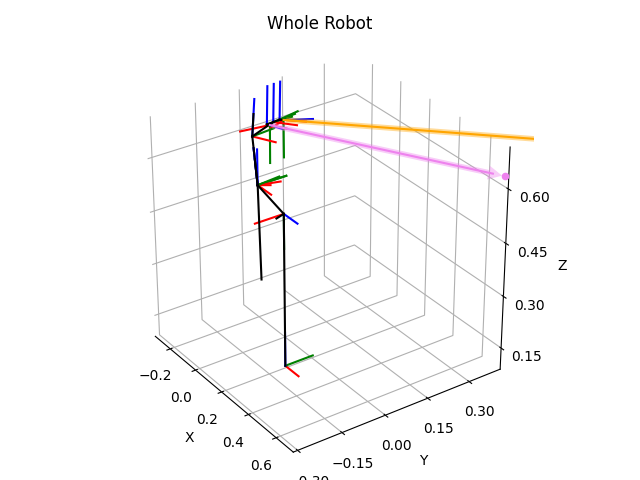

In [27]:
# Plotting

plt.figure()
ax = make_3d_axis(1, 111, unit="m")
ax = tm.plot_frames_in('world', whitelist=["world","torso","realsense","neck","neck_py","head","eyes","lefteye","righteye","leftcamera","rightcamera"],
                       s=0.1, show_name=False, ax=ax)
ax = tm.plot_connections_in("world", ax=ax)

#  Gaze Vectors
T_lprimel = tm.get_transform('leftcamera', 'world')
left_gaze_pts_l = (T_lprimel @ np.array([left_x_prime, left_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
T_rprimer = tm.get_transform('rightcamera', 'world')
right_gaze_pts_r = (T_rprimer @ np.array([right_x_prime, right_y_prime, 1.0, 1.0]).reshape(-1,1)).squeeze()
# Left Gaze
plot_vector(
    start=np.array([T_lprimel[0,3], T_lprimel[1,3], T_lprimel[2,3]]),
    direction=np.array([left_gaze_pts_l[0]-T_lprimel[0,3], left_gaze_pts_l[1]-T_lprimel[1,3], left_gaze_pts_l[2]-T_lprimel[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='orange',
    alpha=0.4
)
ax.plot([T_lprimel[0,3],left_gaze_pts_l[0]],[T_lprimel[1,3],left_gaze_pts_l[1]],[T_lprimel[2,3],left_gaze_pts_l[2]], color='orange')
# Right Gaze
plot_vector(
    start=np.array([T_rprimer[0,3], T_rprimer[1,3], T_rprimer[2,3]]),
    direction=np.array([right_gaze_pts_r[0]-T_rprimer[0,3], right_gaze_pts_r[1]-T_rprimer[1,3], right_gaze_pts_r[2]-T_rprimer[2,3]]),
    s=1.05,
    lw=0,  # Remove line around arrow
    color='violet',
    alpha=0.4
)
ax.plot([T_rprimer[0,3],right_gaze_pts_r[0]],[T_rprimer[1,3],right_gaze_pts_r[1]],[T_rprimer[2,3],right_gaze_pts_r[2]], color='violet')

# Plot Points
T_cworld = tm.get_transform('realsense', 'world')
left_target_pts = (T_cworld @ np.array([X_C_L[0], X_C_L[1], X_C_L[2], 1.0]).reshape(-1,1)).squeeze()
right_target_pts = (T_cworld @ np.array([X_C_R[0], X_C_R[1], X_C_R[2], 1.0]).reshape(-1,1)).squeeze()
ax.scatter([left_target_pts[0]],[left_target_pts[1]],[left_target_pts[2]], color='orange')
ax.scatter([right_target_pts[0]],[right_target_pts[1]],[right_target_pts[2]], color='violet')

ax.view_init(elev=30, azim=-35, roll=0)
ax.set_xlim([-0.3, 0.7])
ax.set_ylim([-0.3, 0.4])
ax.set_zlim([0.1, 0.7])
ax.set_title('Whole Robot')
plt.tight_layout()

## Data Generation (Multiple)

In [28]:
# Robot Construction
robot = URDF.from_xml_file(urdf_path)

# URDF Variable Assignment
for joint in robot.joints:
    if joint.name == 'torso':
        joint.origin.position[0] = 0.0325 + 0  # Offset
        joint.origin.position[1] = -0.05692 + 0
        joint.origin.position[2] = -0.12234 + 0
    elif joint.name == 'neck_pitch':
        joint.origin.rotation[0] = 0 + 0
    elif joint.name == 'head_pitch':
        joint.origin.position[2] = 0.13172 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'eyes_pitch':
        joint.origin.position[0] = 0.08492 + 0
        joint.origin.position[2] = 0.05186 + 0
        joint.origin.rotation[0] = 0 + 0
        joint.origin.rotation[2] = 0 + 0
    elif joint.name == 'lefteye_yaw':
        joint.origin.position[1] = 0.02895 + 0
    elif joint.name == 'righteye_yaw':
        joint.origin.position[1] = -0.02895 + 0
    elif joint.name == 'lefteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = -1.5708 + 0.03457662014401592  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[1] = 0 + 0
        joint.origin.rotation[2] = -1.5708 + 0.18913797017088096  # Orientation Offset: Right Hand Rule (Positive CCW)
    elif joint.name == 'righteye_cam':
        joint.origin.position[0] = 0.015 + 0
        joint.origin.rotation[0] = -1.5708 + 0.05553511593216458  # For Y, Downwards is + because of Camera Opencv Coordinate System
        joint.origin.rotation[1] = 0 + 0
        joint.origin.rotation[2] = -1.5708 + -0.2544206094843146  # Orientation Offset: Right Hand Rule (Positive CCW)
        
# XML to String
urdf_str = xml_to_str(robot)

# Transform Manager
tm = UrdfTransformManager()
tm.load_urdf(urdf_str)

In [29]:
# Initialization
z_depth = 1.0
list_ep=list(range(-14,15,2))
list_et=list(range(20,-31,-5))
list_lnp=list(range(-35,36,5))
list_lnt=list(range(-10,31,10))
list_unt=list(range(40,-11,-10))
data_dict = { 'x_c_l': [],
              'y_c_l': [],
              'z_c_l': [],
              'x_c_r': [],
              'y_c_r': [],
              'z_c_r': [],
              'cmd_theta_lower_neck_pan':[],
              'cmd_theta_lower_neck_tilt':[],
              'cmd_theta_upper_neck_tilt':[],
              'cmd_theta_left_eye_pan': [],
              'cmd_theta_right_eye_pan': [],
              'cmd_theta_eyes_tilt':[],
              'neck_pitch': [],
              'neck_yaw': [],
              'head_pitch': [],
              'eyes_pitch': [],
              'lefteye_yaw': [],
              'righteye_yaw': [],
            }

# Data Generation
for lnt in list_lnt:
    for unt in list_unt:
        for lnp in list_lnp:
            for et in list_et:
                for ep in list_ep:
                    # Robot Commands
                    joint_dict = motor_cmd_joint(cmd_lnp=lnp,cmd_lnt=lnt,cmd_unt=unt,cmd_et=et,cmd_lep=ep,cmd_rep=ep)
                    neck_pitch = joint_dict['neck_pitch']
                    neck_yaw = joint_dict['neck_yaw']
                    head_pitch = joint_dict['head_pitch']
                    eyes_pitch = joint_dict['eyes_pitch']
                    lefteye_yaw = joint_dict['lefteye_yaw']
                    righteye_yaw = joint_dict['righteye_yaw']

                    # Setting Robot Joints
                    tm.set_joint('neck_pitch', neck_pitch)
                    tm.set_joint('neck_yaw', neck_yaw)
                    tm.set_joint('head_pitch', head_pitch)
                    tm.set_joint('eyes_pitch', eyes_pitch)
                    tm.set_joint('lefteye_yaw', lefteye_yaw)
                    tm.set_joint('righteye_yaw', righteye_yaw)
                    
                    # Get Transform
                    T_clprime = tm.get_transform('realsense','leftcamera')
                    T_crprime = tm.get_transform('realsense','rightcamera')
                
                    # Get Camera Chest Points
                    X_C_L = generate_chest_dataset(mat=T_clprime, z=z_depth, x_prime=left_x_prime, y_prime=left_y_prime)
                    X_C_R = generate_chest_dataset(mat=T_crprime, z=z_depth, x_prime=right_x_prime, y_prime=right_y_prime)

                    # Saving Data
                    data_dict['x_c_l'].append(X_C_L[0])
                    data_dict['y_c_l'].append(X_C_L[1])
                    data_dict['z_c_l'].append(X_C_L[2])
                    data_dict['x_c_r'].append(X_C_R[0])
                    data_dict['y_c_r'].append(X_C_R[1])
                    data_dict['z_c_r'].append(X_C_R[2])
                    data_dict['cmd_theta_lower_neck_pan'].append(lnp)
                    data_dict['cmd_theta_lower_neck_tilt'].append(lnt)
                    data_dict['cmd_theta_upper_neck_tilt'].append(unt)
                    data_dict['cmd_theta_left_eye_pan'].append(ep)
                    data_dict['cmd_theta_right_eye_pan'].append(ep)
                    data_dict['cmd_theta_eyes_tilt'].append(et)
                    data_dict['neck_pitch'].append(neck_pitch)
                    data_dict['neck_yaw'].append(neck_yaw)
                    data_dict['head_pitch'].append(head_pitch)
                    data_dict['eyes_pitch'].append(eyes_pitch)
                    data_dict['lefteye_yaw'].append(lefteye_yaw)
                    data_dict['righteye_yaw'].append(righteye_yaw)

In [30]:
# Pandas Dataframe

data_df = pd.DataFrame(data_dict)
print(len(data_df))
data_df.head()

74250


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,cmd_theta_right_eye_pan,cmd_theta_eyes_tilt,neck_pitch,neck_yaw,head_pitch,eyes_pitch,lefteye_yaw,righteye_yaw
0,-0.931616,-0.825672,1.0,-0.908948,-0.822188,1.0,-35,-10,40,-14,-14,20,-0.087266,-0.305433,0.349066,0.139626,-0.390954,-0.415388
1,-0.826077,-0.809452,1.0,-0.794415,-0.804586,1.0,-35,-10,40,-12,-12,20,-0.087266,-0.305433,0.349066,0.139626,-0.335103,-0.356047
2,-0.729375,-0.794590,1.0,-0.690461,-0.788610,1.0,-35,-10,40,-10,-10,20,-0.087266,-0.305433,0.349066,0.139626,-0.279253,-0.296706
3,-0.639909,-0.780841,1.0,-0.595045,-0.773946,1.0,-35,-10,40,-8,-8,20,-0.087266,-0.305433,0.349066,0.139626,-0.223402,-0.237365
4,-0.556395,-0.768006,1.0,-0.506557,-0.760347,1.0,-35,-10,40,-6,-6,20,-0.087266,-0.305433,0.349066,0.139626,-0.167552,-0.178024


In [31]:
# Saving CSV

sim_data_path = os.path.join(os.getcwd(), '..','data','sim','240918_sim_dataset.csv')
data_df.to_csv(sim_data_path , index=False)
print('Saved to:',sim_data_path)

Saved to: /home/jaynieles/dev/grace_dl/notebooks/../data/sim/240918_sim_dataset.csv
